In [1]:
# Import my code
#from tensorfactorization.poisson import *
from tensorfactorization.multiplicative import *
from tensorfactorization.poisson import *
from data.data_imports import load_IL2data, load_indian_pines#, load_kinetic, load_covid19_serology

In [2]:
#%matplotlib widget
import tensorly as tl
import numpy as np
import torch
import math
import time
import random
import matplotlib.pyplot as plt


from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from dataclasses import dataclass, field
from typing import List, Callable

import copy # import copy so that we can do deep copys

import pickle # use pickle to save results to disk


# path to folders for saving data
folder = 'pictures/'
data_folder = 'data/'

# global label variables for all plots
error_label = 'Error'
iteration_label = 'Iteration'
tensor_dimension_label = 'Tensor Dimension'
time_label = 'Time in Seconds'

xscale_convergence_data = {
    'value': 'symlog',
    'linthresh': 1,
    'subs': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'linscale': 0.3,
}
xscale_convergence = 'log'
yscale_convergence = 'log'

In [3]:
def random_cp_with_noise(dimensions, F, noise_scaling=0.1, context={}):
    """
    Create a random CP tensor with some added noise
    """
    true_solution = tl.random.random_cp(dimensions, F, full=True, **context)
    noise = tl.random.random_tensor(dimensions, **context) * noise_scaling * tl.max(true_solution)
    X = true_solution + noise
    return X

In [4]:
def create_initial_data(X, F):
    """
    Create random initial A_ns for our algorithms
    """
    N = X.ndim # get dimension of X
    X_shape = X.shape
    # initialize A_j with random positive values if it was not given
    A_ns = []
    for i in range(N):
        # we use random.random_tensor as it returns a tensor
        A_ns.append(tl.random.random_tensor((X_shape[i], F), **tl.context(X)))
    
    
    
    # rescale
    norm_approx = tl.norm( defactorizing_CP(A_ns, X.shape) )
    scaling = (tl.norm(X) / norm_approx) ** (1.0/ X.ndim)
    for n in range(len(A_ns)):
        A_ns[n] = A_ns[n] * scaling
    return A_ns

# Function for testing algorithms on actual data

In [5]:
# Dataclasses

@dataclass
class IterationResult:
    """ data class that holds the plotting information for one algorithm execution. Should only be used as a part of SolverData
    
    Attributes
    ----------
    reconstruction_errors (list): List or array of the reconstruction errors
    calculation_time (float): Total time it took to run the algorithm
    A_ns: final approximation factors
    
    """
    reconstruction_errors: tl.tensor
    calculation_time: float
    A_ns: List


@dataclass
class Factorizer:
    """ data class that holds the plotting results of all executions for one algorithm
    
    Attributes
    ----------
    label (str): label for the plot
    algorithm (Callable): the actual factorization algorithm. Takes a tensor, an integer and initial_A_ns as input and has an IterantionResult as output
    args (List): List of arguments for the solver.
    color (str): color for the plot. Defaults to 'red'.
    linestyle (str): linestyle for the plot. Defaults to 'solid'.
    data (List): list of IterationResults for the individual executions of the algorithm
    
    """
    label: str
    algorithm: Callable # input tensor, int and initial_A_ns, output IterationResult
    #args: List = field(default_factory=list)
    color: str = 'red'
    linestyle: str = 'solid'
    data: List[IterationResult] = field(default_factory=list) 

    # If args was not given, then default it to [self.label]
    #def __post_init__(self):
    #    if not self.args:
    #        self.args = [self.label]

    def factorize_cp(self, tensor, F, initial_A_ns) -> IterationResult:
        """ Runs the algorithm and saves the result and returns it as well
        """
        result = self.algorithm(tensor, F, initial_A_ns)
        self.add_data(result)
        return result
    
    def add_data(self, iteration_result):
        self.data.append(iteration_result)
    
    def get_calculation_times(self):
        """returns a list of the calculation times of all IterationResults in data
        """
        return [ir.calculation_time for ir in self.data]

    def average_calculation_time(self):
        calc_times = self.get_calculation_times()
        return sum(calc_times)/len(calc_times)

    def get_calculation_times_per_iteration(self):
        """ If there where no iterations use 0
        """
        return [ir.calculation_time/(len(ir.reconstruction_errors)-1) if len(ir.reconstruction_errors) > 1 else 0 for ir in self.data]




In [18]:
# Which tensordata is usable:
# covid19: not non-negative so not usable
# IL2: needs masks but is ok otherwise
# indian pines: possible
# kinetic: not non-negative so not usable

# can also use "data/vaccine_tensor.npy" to get a integer tensor


from skimage import data

dimensions = [
    (10,10,10),
    (20,20,5),
    (10,10,10,5),
    (10,10,5,5,5),
    (100,100,3),
]


# all color images from skimage.data sorted by size
default_F = 3
image_names = [
    {"name": 'colorwheel', "F": default_F}, # (370, 371, 3)
    {"name": 'cat', "F": 4}, # (300, 451, 3)
    {"name": 'coffee', "F": 4}, # (400, 600, 3)
    {"name": 'astronaut', "F": 5}, # (512, 512, 3)
    {"name": 'immunohistochemistry', "F": 5}, # (512, 512, 3)
    {"name": 'rocket', "F": 4}, # (427, 640, 3)
    {"name": 'logo', "F": 4}, # (500, 500, 4)
    {"name": 'hubble_deep_field', "F": 5}, # (872, 1000, 3)
#    {"name": 'skin', "F": default_F}, # (960, 1280, 3)
#    {"name": 'lily', "F": default_F}, # (922, 922, 4)
    {"name": 'retina', "F": 5}, # (1411, 1411, 3)
]

#image_names = [
#    {"name": 'colorwheel', "F": default_F}, # (370, 371, 3)
#    {"name": 'cat', "F": default_F}, # (300, 451, 3)
#]

max_iter = 2000

def to_image(tensor):
    """A convenience function to convert from a float dtype back to uint8"""
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)


def evaluate_algorithms(factorizers: List[Factorizer], context={"dtype": tl.float64}):
    """
    Evalue the alogirhtm factorization_algorithm on actual data.

    Args:
        factorizers (List[Factorizers): List of Factorizers we want to evaluate
        context (dict): context for the tensors using tensorly
        algorithm_args (dict): additional arguments for the algorithm
    """

    # testing on random data
    print("\nTesting on random generated tensors:")
    for dimension in dimensions:
        F = random.randint(2, 5) # get random order between 2 and 5
        norm_of_tensor = random.uniform(1.0, 500.0) # get a random norm for our tensor
        noise_scaling = max(0, random.uniform(-0.05, 0.2))
        
        print("Dimension of tensor: " + str(dimension) + ", noise: " + str(noise_scaling) + ", F: " + str(F) + ", norm: " + str(norm_of_tensor))
        
        tensor = random_cp_with_noise(dimension, F, noise_scaling=0.0, context=context) # make it have no noise
        tensor = tensor * norm_of_tensor / tl.norm(tensor) # rescale the tensor
        # generate initial A_ns
        initial_A_ns = create_initial_data(tensor, F)
        
        plt.figure()
        for factorzer in factorizers:
            iteration_result = factorzer.factorize_cp(tensor, F, initial_A_ns)
            reconstruction = defactorizing_CP(iteration_result.A_ns, tensor.shape)
            
            print(factorzer.label + " converged in " + str(iteration_result.calculation_time) + "seconds and " + str(len(iteration_result.reconstruction_errors)) + " iterations")
            
            plt.plot(iteration_result.reconstruction_errors, color=factorzer.color, label=factorzer.label, linestyle=factorzer.linestyle)
            
        plt.xlabel(iteration_label)
        plt.ylabel(error_label)
        # TODO das mal noch genauer anschauen, was da sinnvoll ist
        plt.yscale(yscale_convergence)
        #plt.xscale(xscale_convergence)
        plt.xscale(**xscale_convergence_data)
        plt.xlim(left=0)
        plt.legend(title='Algorithms', loc='upper right')
        plt.title('Tensor of Dimension ' + str(dimension))
        #plt.show()
        plt.savefig(folder+'random_'+str(dimension)+'_convergence.png')

    # TODO IL2 needs mask

    # test on indian pines data
    print("\nTesting on indian pines data:")
    indian_pines = load_indian_pines()
    tensor = tl.tensor(indian_pines.tensor, **context)
    print("Tensor is of shape: " + str(tensor.shape))
    F = 4 # TODO find good F here
    # generate initial A_ns
    initial_A_ns = create_initial_data(tensor, F)
    plt.figure()
    for factorzer in factorizers:
        iteration_result = factorzer.factorize_cp(tensor, F, initial_A_ns)
        reconstruction = defactorizing_CP(iteration_result.A_ns, tensor.shape)
        
        print(factorzer.label + " converged in " + str(iteration_result.calculation_time) + "seconds and " + str(len(iteration_result.reconstruction_errors)) + " iterations")
        
        plt.plot(iteration_result.reconstruction_errors, color=factorzer.color, label=factorzer.label, linestyle=factorzer.linestyle)
    plt.xlabel(iteration_label)
    plt.ylabel(error_label)
    # TODO das mal noch genauer anschauen, was da sinnvoll ist
    plt.yscale(yscale_convergence)
    #plt.xscale(xscale_convergence)
    plt.xscale(**xscale_convergence_data)
    plt.xlim(left=0)
    plt.legend(title='Algorithms', loc='upper right')
    plt.title('Indian Pines Data')
    #plt.show()
    plt.savefig(folder+'data_indian_pines_convergence.png')


    # test on vaccines data
    print("\nTesting on vaccine data:")
    vaccine_data = np.load("data/vaccine_tensor.npy")
    tensor = tl.tensor(vaccine_data, **context)
    print("Tensor is of shape: " + str(tensor.shape))
    F = 4 # TODO find good F here
    # generate initial A_ns
    initial_A_ns = create_initial_data(tensor, F)
    plt.figure()
    for factorzer in factorizers:
        iteration_result = factorzer.factorize_cp(tensor, F, initial_A_ns)
        reconstruction = defactorizing_CP(iteration_result.A_ns, tensor.shape)
        
        print(factorzer.label + " converged in " + str(iteration_result.calculation_time) + "seconds and " + str(len(iteration_result.reconstruction_errors)) + " iterations")
        
        plt.plot(iteration_result.reconstruction_errors, color=factorzer.color, label=factorzer.label, linestyle=factorzer.linestyle)
    plt.xlabel(iteration_label)
    plt.ylabel(error_label)
    # TODO das mal noch genauer anschauen, was da sinnvoll ist
    plt.yscale(yscale_convergence)
    #plt.xscale(xscale_convergence)
    plt.xscale(**xscale_convergence_data)
    plt.xlim(left=0)
    plt.legend(title='Algorithms', loc='upper right')
    plt.title('Vaccine Data')
    #plt.show()
    plt.savefig(folder+'data_vaccines_convergence.png')
    
    
    # test on images
    for name in image_names:
        print("\nFactorizing image "+name["name"]+"with F = "+str(name["F"]))
        # get the image
        caller = getattr(data, name["name"])
        image = caller()
        tensor = tl.tensor(image, **context)

        F = name["F"]

        # generate initial A_ns
        initial_A_ns = create_initial_data(tensor, F)
        
        # Plot the resulting image and the convergence lines
        fig, axes = plt.subplots(nrows=1, ncols=len(factorizers)+1, figsize=(20, 20))
        # create subplots for the convergence lines
        plt.figure()
        axes_index = 0 # index of the axes
        # original image
        axes[axes_index].set_title(name["name"])
        axes[axes_index].set_axis_off()
        if tensor.ndim == 2:
            axes[axes_index].imshow(to_image(tensor), cmap=plt.cm.gray)
        else:
            axes[axes_index].imshow(to_image(tensor))
        
        # iterate over all factorizers, let them run, save the data
        for factorzer in factorizers:
            axes_index += 1
            iteration_result = factorzer.factorize_cp(tensor, F, initial_A_ns)
            reconstruction = defactorizing_CP(iteration_result.A_ns, tensor.shape)

            print(factorzer.label + " converged in " + str(iteration_result.calculation_time) + "seconds and " + str(len(iteration_result.reconstruction_errors)) + " iterations")
            
            axes[axes_index].set_title(factorzer.label)
            axes[axes_index].set_xticks([])
            axes[axes_index].set_yticks([])
            if tensor.ndim == 2:
                axes[axes_index].imshow(to_image(reconstruction), cmap=plt.cm.gray)
            else:
                axes[axes_index].imshow(to_image(reconstruction))

            plt.plot(iteration_result.reconstruction_errors, color=factorzer.color, label=factorzer.label, linestyle=factorzer.linestyle)

        #fig.show()
        fig.savefig(folder+'image_'+name["name"]+'_reconstruction.png', bbox_inches='tight')

        plt.xlabel(iteration_label)
        plt.ylabel(error_label)
        # TODO das mal noch genauer anschauen, was da sinnvoll ist
        plt.yscale(yscale_convergence)
        #plt.xscale(xscale_convergence)
        plt.xscale(**xscale_convergence_data)
        plt.xlim(left=0)
        plt.legend(title='Algorithms', loc='upper right')
        plt.title(name["name"]+" with F = "+str(name["F"]))
        #plt.show()
        plt.savefig(folder+'image_'+name["name"]+'_convergence.png')
        plt.close(fig)

# TODO add saving of data


Testing on random generated tensors:
Dimension of tensor: (10, 10, 10), noise: 0.13006550541426698, F: 3, norm: 199.7499943263044
Multiplicative converged in 0.4703257083892822seconds and 425 iterations
Multiplicative Poisson converged in 1.4444897174835205seconds and 843 iterations
Geometric step size calculation converged in 1.7471816539764404seconds and 269 iterations
Dimension of tensor: (20, 20, 5), noise: 0, F: 3, norm: 392.92303546670985
Multiplicative converged in 0.9762356281280518seconds and 1111 iterations
Multiplicative Poisson converged in 0.9807674884796143seconds and 506 iterations
Geometric step size calculation converged in 0.8102028369903564seconds and 121 iterations
Dimension of tensor: (10, 10, 10, 5), noise: 0.15237700243493119, F: 2, norm: 143.07489959002967
Multiplicative converged in 0.35504770278930664seconds and 297 iterations
Multiplicative Poisson converged in 0.21099853515625seconds and 112 iterations
Geometric step size calculation converged in 1.03811168

C:\Users\David\AppData\Local\Temp\ipykernel_24852\1207743542.py:50: RuntimeWarning: invalid value encountered in cast
  return im.astype(np.uint8)


Geometric step size calculation converged in 0.3324470520019531seconds and 32 iterations

Factorizing image cat
Multiplicative converged in 0.7088162899017334seconds and 668 iterations
Multiplicative Poisson converged in 0.5962634086608887seconds and 255 iterations
Geometric step size calculation converged in 0.8679995536804199seconds and 85 iterations

Factorizing image coffee
Multiplicative converged in 1.0303492546081543seconds and 796 iterations
Multiplicative Poisson converged in 1.0560076236724854seconds and 393 iterations
Geometric step size calculation converged in 1.3855431079864502seconds and 111 iterations

Factorizing image astronaut
Multiplicative converged in 0.5861058235168457seconds and 388 iterations
Multiplicative Poisson converged in 0.33725810050964355seconds and 91 iterations
Geometric step size calculation converged in 0.45722365379333496seconds and 37 iterations

Factorizing image immunohistochemistry
Multiplicative converged in 0.8490536212921143seconds and 630 

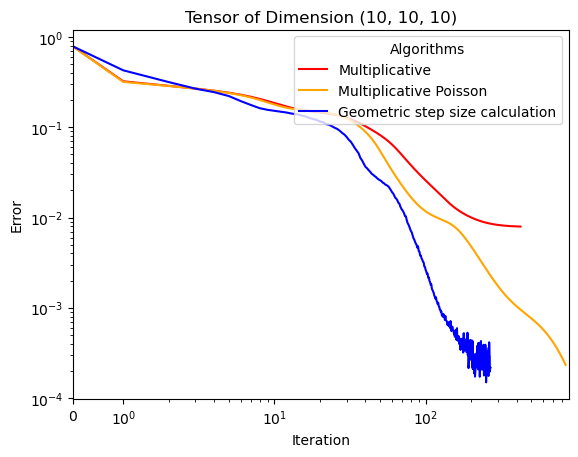

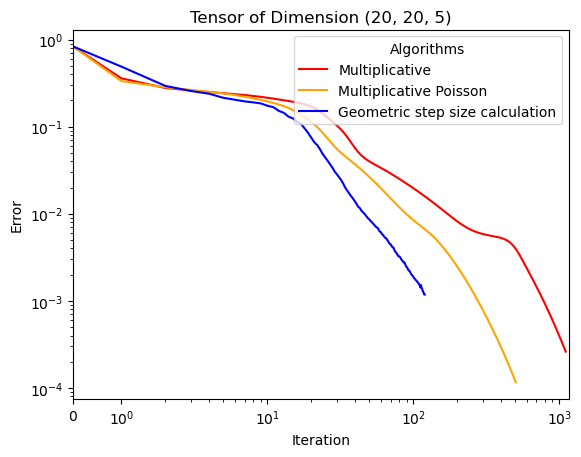

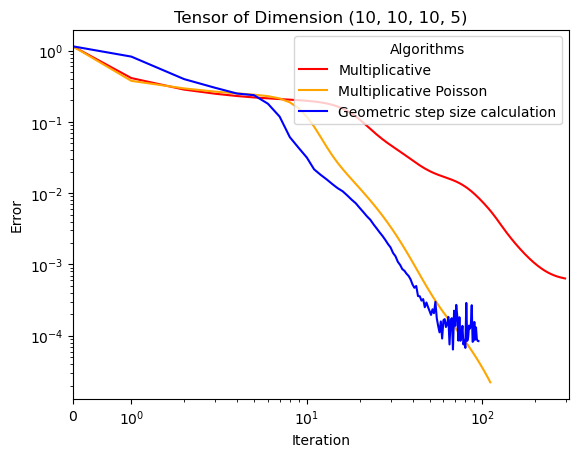

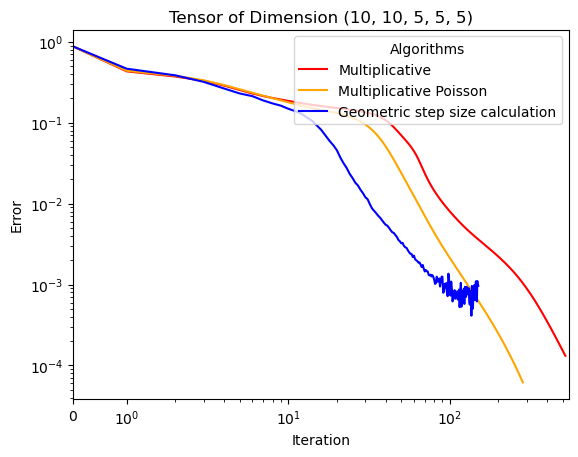

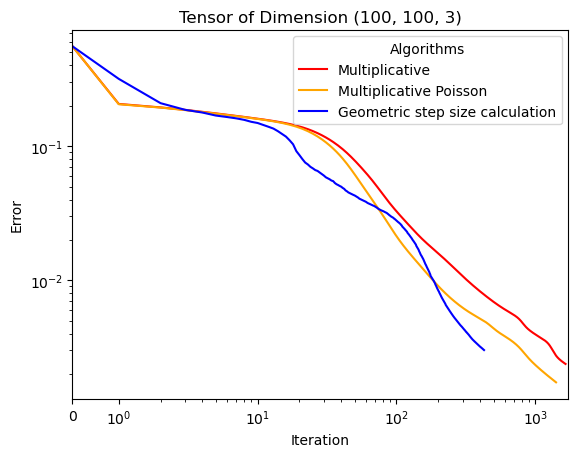

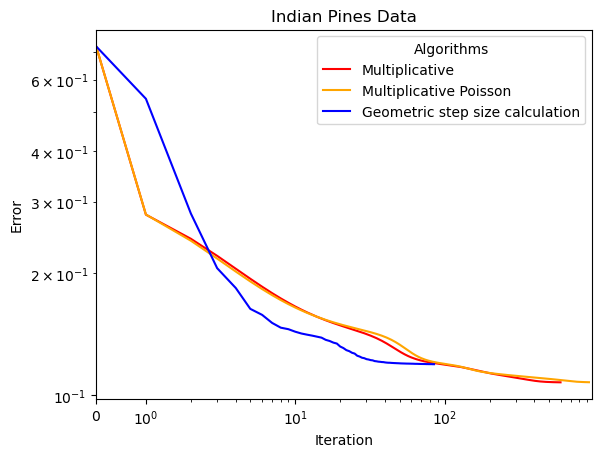

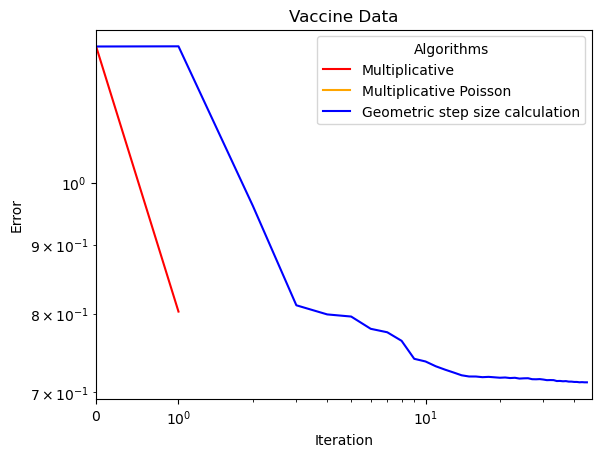

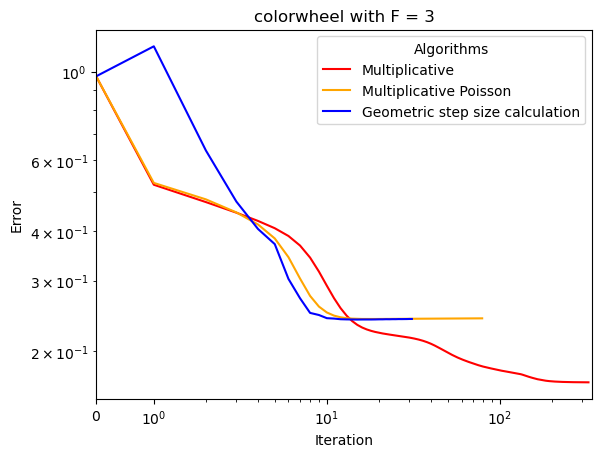

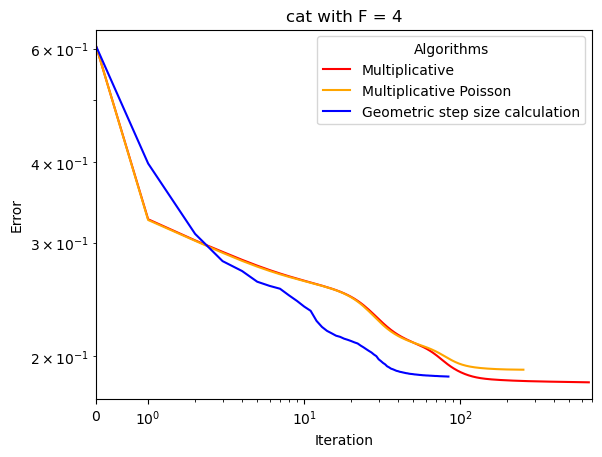

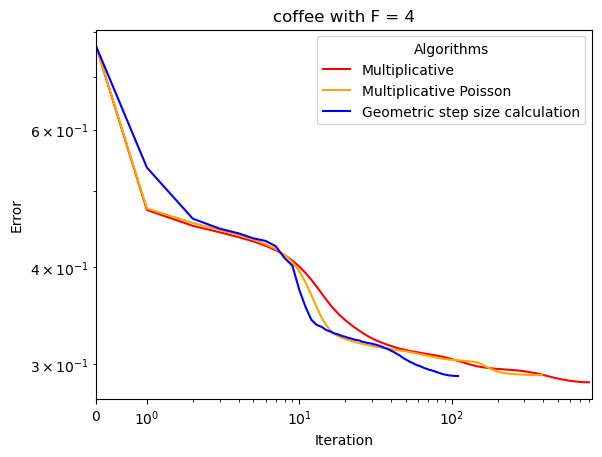

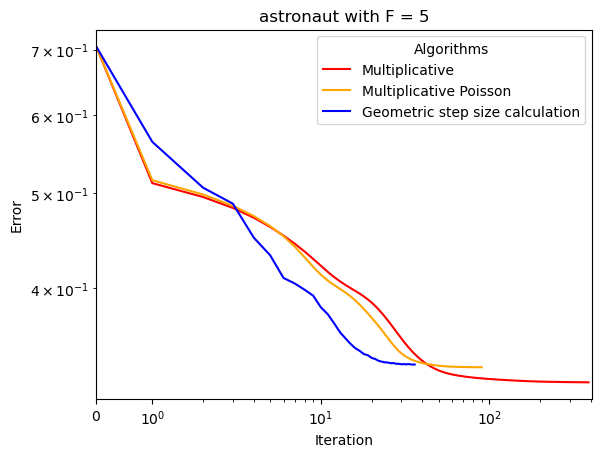

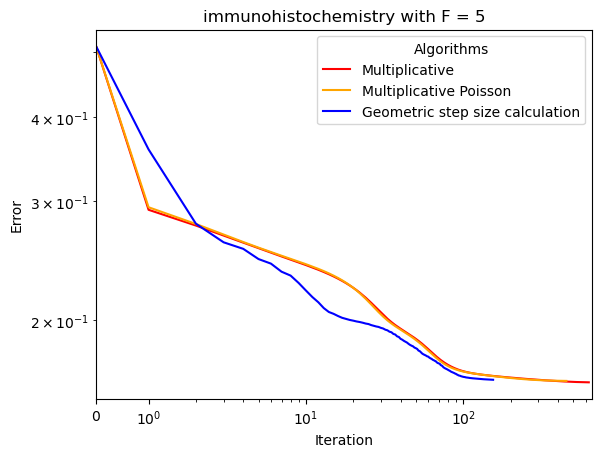

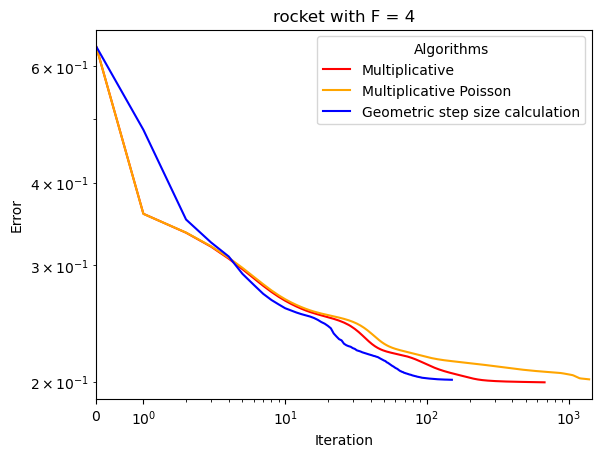

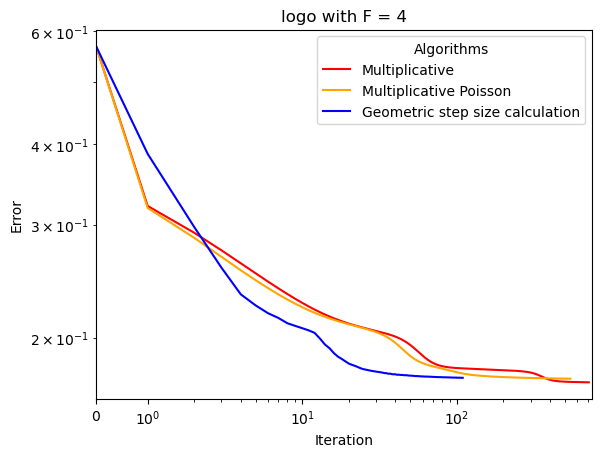

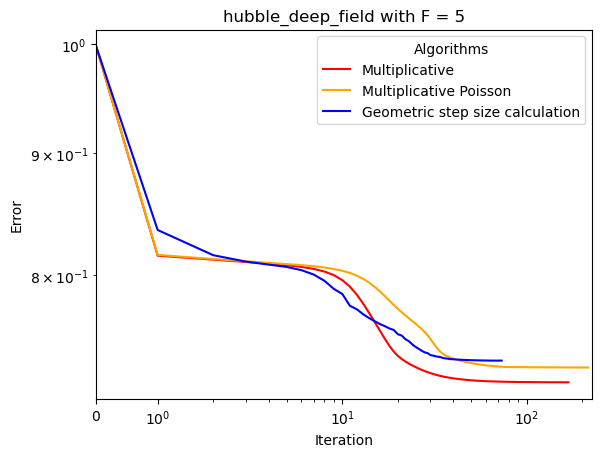

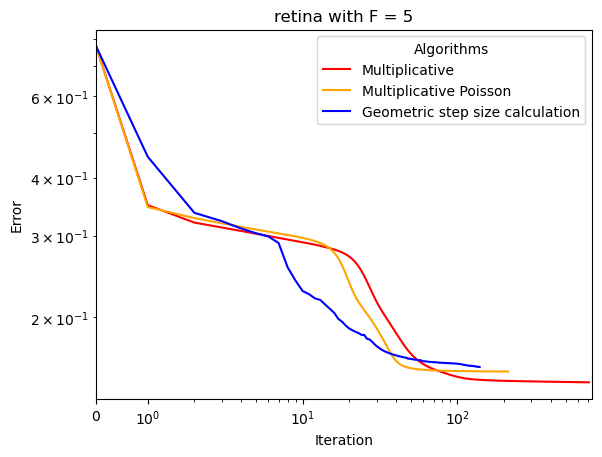

In [19]:
def multiplicative_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)

factorizer_multiplicative = Factorizer("Multiplicative", multiplicative_factorization, color='red')

def multiplicative_poisson_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative_poisson(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)

factorizer_multiplicative_poisson = Factorizer("Multiplicative Poisson", multiplicative_poisson_factorization, color='orange')

def geometric_variable_step_size(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)

factorizer_geometric = Factorizer("Geometric step size calculation", geometric_variable_step_size, color='blue')

tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
#context = {}
evaluate_algorithms([factorizer_multiplicative, factorizer_multiplicative_poisson, factorizer_geometric], context=context)

In [8]:
print(tl.eps(tl.float32))

1.1920928955078125e-07


# Testing Geometric Poisson Algorithm

## Testing Approximating Everytime

In [16]:
# first test numpy backend
tl.set_backend('numpy')

tensor = random_cp_with_noise((10, 10, 10), 2)
print(tl.context(tensor))

{'dtype': dtype('float64')}


C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\__init__.py:206: RuntimeWarning: overflow encountered in exp
  return getattr(



 
 Update_approximation_everytime = False 
 

took 5.6360015869140625 seconds with final error 0.18006260102895558

 
 Update_approximation_everytime = True 
 

took 6.131999492645264 seconds with final error 0.1465261224953962


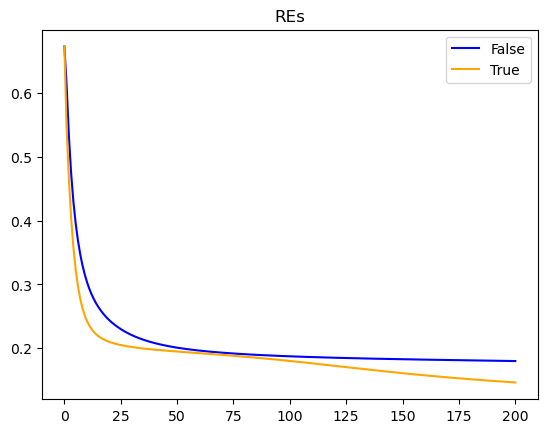

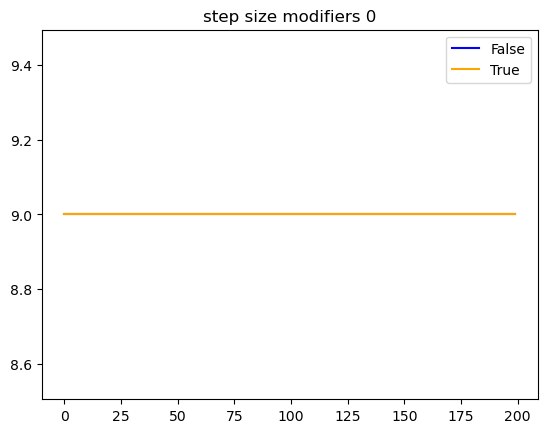

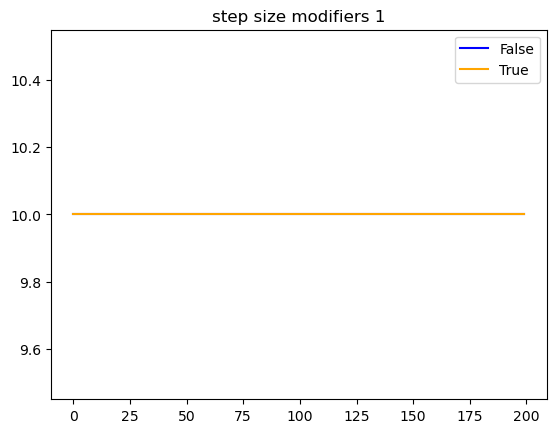

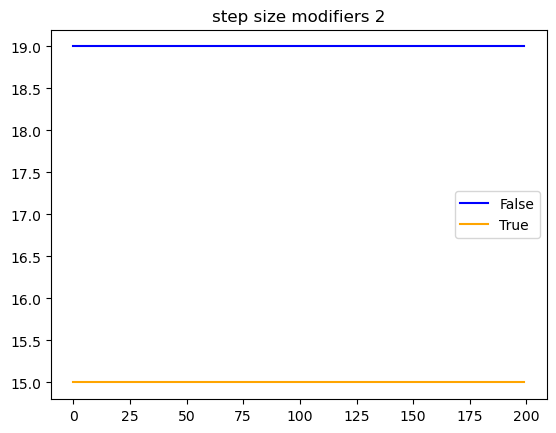

In [5]:
# first lets compare update_approximation_everytime
dimension = (300, 300, 3)
F = 3
max_iter = 200
verbose = False

tensor = random_cp_with_noise(dimension, F)
# create initial data for both
initial_A_ns = create_initial_data(tensor, F)

# Without update_approximation_everytime
start = time.time()
_, RE_false, approx_false, step_size_modifiers_false = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, update_approximation_everytime=False, initial_A_ns=initial_A_ns)
end = time.time()
time_false = end - start
print("\n \n Update_approximation_everytime = False \n \n")
print("took " + str(time_false) + " seconds with final error " + str(RE_false[-1]))

# with update_approximation_everytime
start = time.time()
_, RE_true, approx_true, step_size_modifiers_true = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, update_approximation_everytime=True, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Update_approximation_everytime = True \n \n")
print("took " + str(time_true) + " seconds with final error " + str(RE_true[-1]))


plt.plot(RE_false, label="False", color="blue")
plt.plot(RE_true, label="True", color="orange")
plt.title("REs")
plt.legend()
plt.show()

for n in range(F):
    plt.plot(step_size_modifiers_false[n], label="False", color="blue")
    plt.plot(step_size_modifiers_true[n], label="True", color="orange")
    plt.title("step size modifiers " + str(n))
    plt.legend()
    plt.show()

## General testing with prints

Current index: 0
Initial m = 5
-2.891328751007388
-0.6931471805599453
Time from start to calculate gradients and first next iterate: 0.02300095558166504
Time from start until end of step size calculation: 0.027001142501831055
Biggest element in -gradient: tensor(3359.1033)
smallest element in -gradient: tensor(-192.6819)
Step Size: 0.001953125
m: 8
Step size * biggest element: tensor(6.5607)
biggest element in A_n: tensor(0.9963)
smallest element in A_n: tensor(0.0079)
Shape of approximated_X_unfolded_n: torch.Size([300, 900])
Shape of khatri Rao product: torch.Size([900, 3])
Calculculation time: 0.031000852584838867
New objective function value: tensor(251164.5625)
function_value_at_iteration = tensor(274167.2188)
norm_of_rg = tensor(19758940.)
biggest Element of X/M = tensor(229.8754)


Current index: 1
Initial m = 5
-2.865747701719853
-0.6931471805599453
Time from start to calculate gradients and first next iterate: 0.001003265380859375
Time from start until end of step size calcula

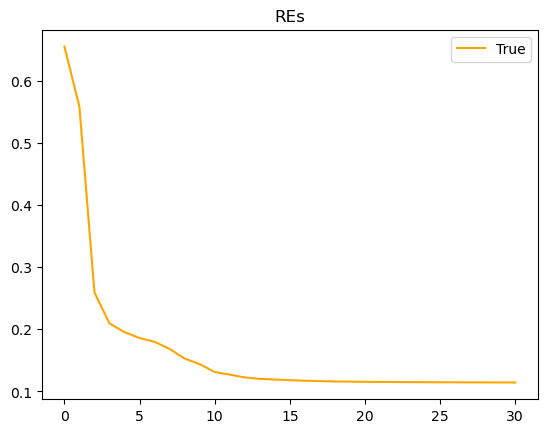

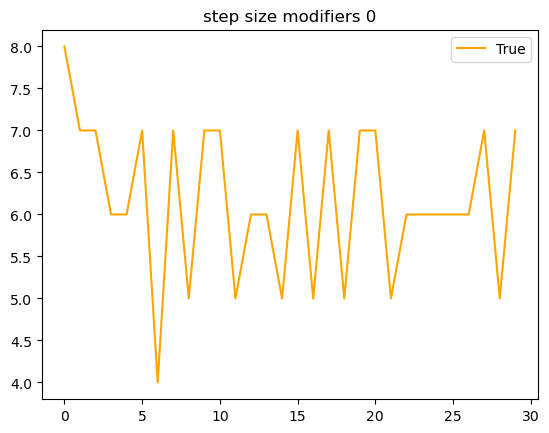

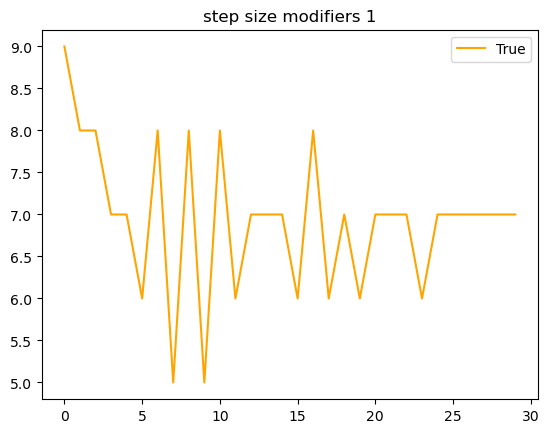

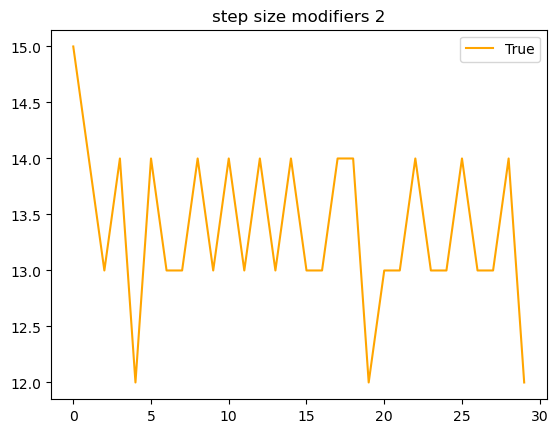

In [9]:
# Now lets do some printing
dimension = (300, 300, 3)
F = 3
max_iter = 30
verbose = True

tensor = random_cp_with_noise(dimension, F)
# create initial data for both
initial_A_ns = create_initial_data(tensor, F)


# with update_approximation_everytime
start = time.time()
_, RE_true, approx_true, step_size_modifiers_true = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, update_approximation_everytime=True, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Update_approximation_everytime = True \n \n")
print("took " + str(time_true) + " seconds with final error " + str(RE_true[-1]))


plt.plot(RE_true, label="True", color="orange")
plt.title("REs")
plt.legend()
plt.show()

for n in range(F):
    plt.plot(step_size_modifiers_true[n], label="True", color="orange")
    plt.title("step size modifiers " + str(n))
    plt.legend()
    plt.show()

## Testing Scaling the tensor


 
 Tensor between 0 and 1
took 0.36899828910827637 seconds with final error 0.08913786527393355

 
 Tensor between 0 and 100 but no scalling of A_ns
took 1.2860000133514404 seconds with final error 0.08971621040068666

 
 Tensor between 0 and 100 but no scalling of A_ns
took 1.7200000286102295 seconds with final error 0.3635031246803288

 
 Tensor between 0 and 100 but no scalling of A_ns
took 0.5209999084472656 seconds with final error 0.08915045364162126


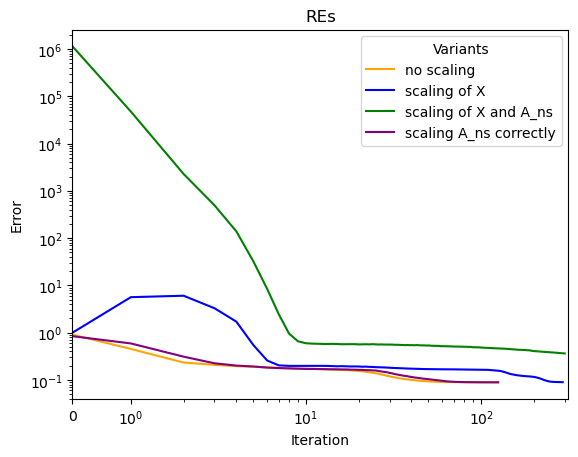

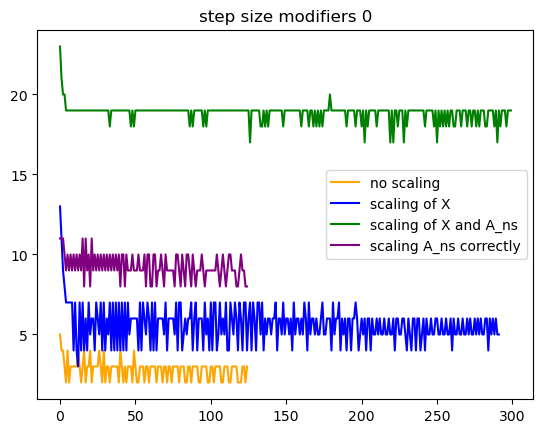

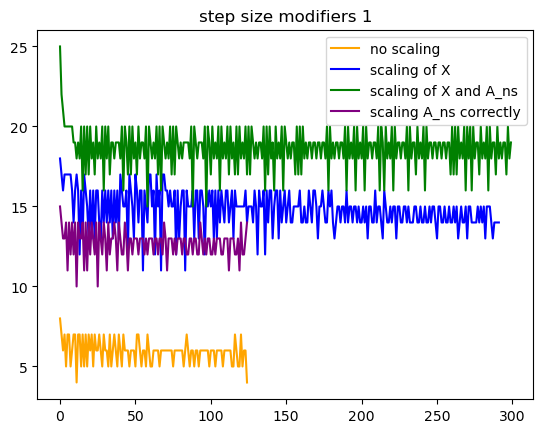

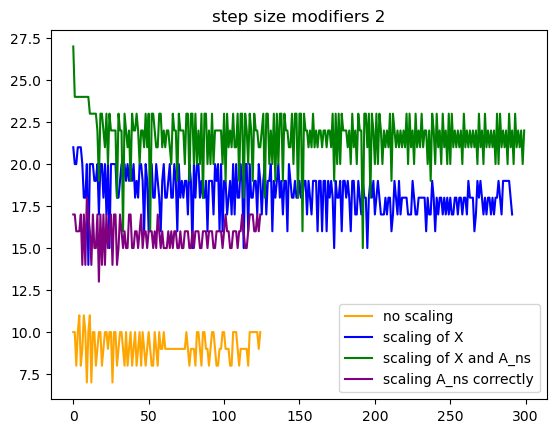

In [36]:
dimension = (300, 30, 3)
F = 3
max_iter = 300
verbose = False

scaling = 1000.0

tensor = random_cp_with_noise(dimension, F, noise_scaling=0.1)
# create initial data for both
initial_A_ns = create_initial_data(tensor, F)

plt.figure()
# All elements between 0 and 1
start = time.time()
_, RE_no_scaling, approx_no_scaling, step_size_modifiers_no_scaling = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Tensor between 0 and 1")
print("took " + str(time_true) + " seconds with final error " + str(RE_no_scaling[-1]))
plt.plot(RE_no_scaling, label="no scaling", color="orange")

# All elements between 0 and 100 but no scaling of inital A_ns
tensor = tensor * scaling
start = time.time()
_, RE_scaling, approx_scaling, step_size_modifiers_scaling = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Tensor between 0 and 100 but no scalling of A_ns")
print("took " + str(time_true) + " seconds with final error " + str(RE_scaling[-1]))
plt.plot(RE_scaling, label="scaling of X", color="blue")

# All elements between 0 and 100 and scaling of A_ns to be between 0 and 100
for n in range(len(initial_A_ns)):
    initial_A_ns[n] = initial_A_ns[n] * scaling
start = time.time()
_, RE_scaling_all, approx_scaling_all, step_size_modifiers_scaling_all = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Tensor between 0 and 100 but no scalling of A_ns")
print("took " + str(time_true) + " seconds with final error " + str(RE_scaling_all[-1]))
plt.plot(RE_scaling_all, label="scaling of X and A_ns", color="green")



# Rescaling A_ns so that norm of approx is same as tensor X
# TODO think about if that is the correct method or if we want something better
norm_X = tl.norm(tensor)
norm_approx = tl.norm( defactorizing_CP(initial_A_ns, tensor.shape) )
# since we want to equally divide the scalling amongst the factors, we need to take the nth root
scaling = (norm_X / norm_approx) ** (1.0/ tensor.ndim)

for n in range(len(initial_A_ns)):
    initial_A_ns[n] = initial_A_ns[n] * scaling
start = time.time()
_, RE_scaling_perfect, approx_scaling_perfect, step_size_modifiers_scaling_perfect = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Tensor between 0 and 100 but no scalling of A_ns")
print("took " + str(time_true) + " seconds with final error " + str(RE_scaling_perfect[-1]))
plt.plot(RE_scaling_perfect, label="scaling A_ns correctly", color="purple")





plt.title("REs")
plt.xlabel(iteration_label)
plt.ylabel(error_label)
# TODO das mal noch genauer anschauen, was da sinnvoll ist
plt.yscale(yscale_convergence)
#plt.xscale(xscale_convergence)
plt.xscale(**xscale_convergence_data)
plt.xlim(left=0)
plt.legend(title='Variants', loc='upper right')
plt.figure()


for n in range(F):
    plt.plot(step_size_modifiers_no_scaling[n], label="no scaling", color="orange")
    plt.plot(step_size_modifiers_scaling[n], label="scaling of X", color="blue")
    plt.plot(step_size_modifiers_scaling_all[n], label="scaling of X and A_ns", color="green")
    plt.plot(step_size_modifiers_scaling_perfect[n], label="scaling A_ns correctly", color="purple")
    plt.title("step size modifiers " + str(n))
    plt.legend()
    plt.show()


 
 Tensor between 0 and 1
took 3.3205406665802 seconds with final error 0.2409887079301309

 
 Tensor between 0 and 100 but no scalling of A_ns
took 2.7565717697143555 seconds with final error 0.2405849450644301


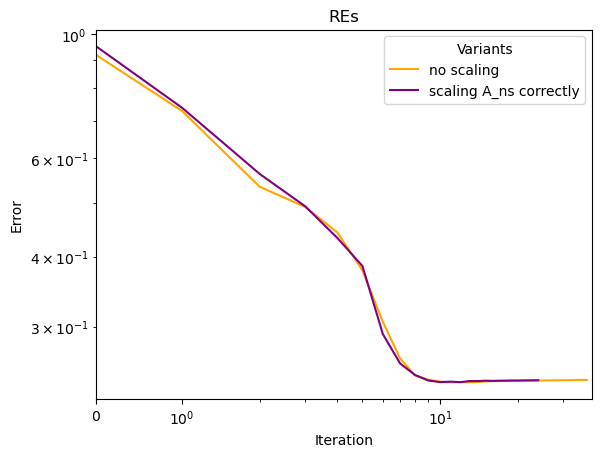

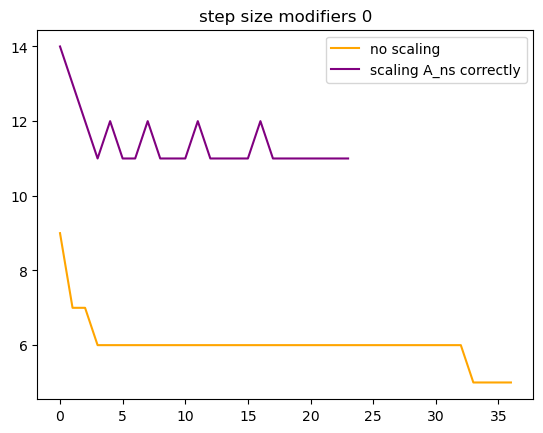

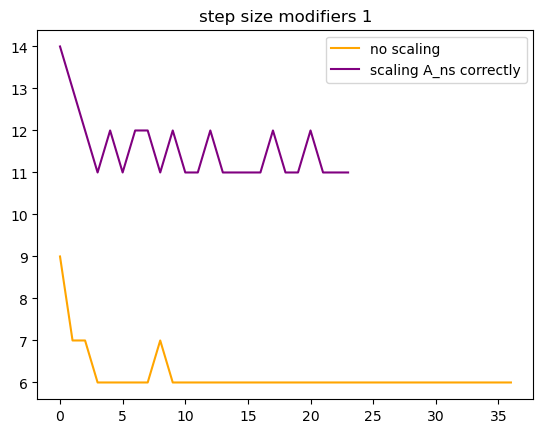

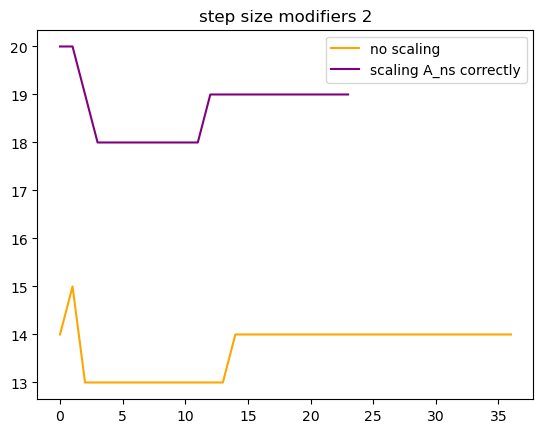

In [16]:
dimension = (300, 30, 3)
F = 3
max_iter = 300
verbose = False

scaling = 255.0

tensor = tl.tensor(data.colorwheel(), dtype=tl.float64) / 255.0
# create initial data for both
initial_A_ns = create_initial_data(tensor, F)

plt.figure()
# All elements between 0 and 1
start = time.time()
_, RE_no_scaling, approx_no_scaling, step_size_modifiers_no_scaling = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Tensor between 0 and 1")
print("took " + str(time_true) + " seconds with final error " + str(RE_no_scaling[-1]))
plt.plot(RE_no_scaling, label="no scaling", color="orange")


tensor = tl.tensor(data.colorwheel(), dtype=tl.float64)
# Rescaling A_ns so that norm of approx is same as tensor X
# TODO think about if that is the correct method or if we want something better
norm_X = tl.norm(tensor)
norm_approx = tl.norm( defactorizing_CP(initial_A_ns, tensor.shape) )
# since we want to equally divide the scalling amongst the factors, we need to take the nth root
scaling = (norm_X / norm_approx) ** (1.0/ tensor.ndim)

for n in range(len(initial_A_ns)):
    initial_A_ns[n] = initial_A_ns[n] * scaling
start = time.time()
_, RE_scaling_perfect, approx_scaling_perfect, step_size_modifiers_scaling_perfect = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Tensor between 0 and 100 but no scalling of A_ns")
print("took " + str(time_true) + " seconds with final error " + str(RE_scaling_perfect[-1]))
plt.plot(RE_scaling_perfect, label="scaling A_ns correctly", color="purple")





plt.title("REs")
plt.xlabel(iteration_label)
plt.ylabel(error_label)
# TODO das mal noch genauer anschauen, was da sinnvoll ist
plt.yscale(yscale_convergence)
#plt.xscale(xscale_convergence)
plt.xscale(**xscale_convergence_data)
plt.xlim(left=0)
plt.legend(title='Variants', loc='upper right')
plt.figure()


for n in range(F):
    plt.plot(step_size_modifiers_no_scaling[n], label="no scaling", color="orange")
    plt.plot(step_size_modifiers_scaling_perfect[n], label="scaling A_ns correctly", color="purple")
    plt.title("step size modifiers " + str(n))
    plt.legend()
    plt.show()

## Finding Optimal Step Size

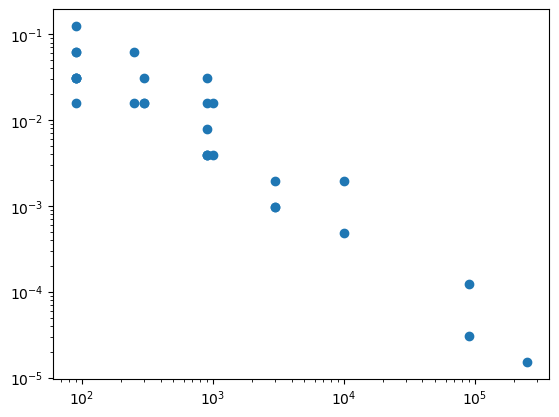

In [15]:
# TODO: find a method to automatically gather and plot this data and then automatically calculate the m and the B!!!!
# let us plot the step size with the size of the contraction, i.e. khatri_rao_product.shape[0]
data = [ # (30, 30, 3)
    (90, 0.015625),
    (90, 0.03125),
    (90, 0.03125),
    (90, 0.03125),
    (90, 0.0625),
    (900, 0.00390625),
    (900, 0.0078125),
    # (100, 30, 3)
    (90, 0.03125),
    (90, 0.125),
    (90, 0.0625),
    (300, 0.015625),
    (300, 0.015625),
    (300, 0.03125),
    (3000, 0.001953125),
    (3000, 0.0009765625),
    (3000, 0.0009765625),
    # (200, 50, 5)
    (250, 0.015625),
    (250, 0.0625),
    (1000, 0.00390625),
    (1000, 0.015625),
    (10000, 0.001953125),
    (10000, 0.00048828125),
    # (300, 300, 3)
    (900, 0.00390625),
    (900, 0.015625),
    (900, 0.03125),
    (900, 0.00390625),
    (90000, 3.0517578125e-05),
    (90000, 0.0001220703125),
    # some more points in the extremes
    (250000, 1.52587890625e-05),
    
    ]

plt.scatter(*zip(*data))
plt.yscale('log')
plt.xscale('log')
plt.show()
# this looks like a line

In [18]:
m = (math.log10(2e-5) - math.log10(0.0625)) / (math.log10(250000) - math.log10(90))
print(m)
print(0.0625*90)

# This means that step size \approx 5 / khatri_rao_product.shape[0]

-1.014853953478428
5.625


 
 
 Sigma = 0.5
Dimension of new tensor: [6, 146, 33, 3]
doing 8 iteration steps, with a norm of 121.09710413061616
done with factorization
Dimension of new tensor: [94, 7, 15, 4, 4]
doing 9 iteration steps, with a norm of 437.7211895035831


C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\__init__.py:206: RuntimeWarning: divide by zero encountered in log
  return getattr(


done with factorization
Dimension of new tensor: [164, 54, 5, 4]
doing 10 iteration steps, with a norm of 10.550193246667057
done with factorization
Dimension of new tensor: [6, 99, 10, 7, 3]
doing 8 iteration steps, with a norm of 19.82402193155037
done with factorization
Dimension of new tensor: [59, 19, 15, 3, 3]
doing 8 iteration steps, with a norm of 493.65940181805735
done with factorization
Dimension of new tensor: [159, 23, 4, 4, 3]
doing 6 iteration steps, with a norm of 50.02639753778689
done with factorization
Dimension of new tensor: [137, 102, 4, 3]
doing 9 iteration steps, with a norm of 128.2897167391985
done with factorization
Dimension of new tensor: [59, 148, 5, 3]
doing 7 iteration steps, with a norm of 165.26128854681713
done with factorization
Dimension of new tensor: [156, 34, 5, 5]
doing 7 iteration steps, with a norm of 142.10448012361783
done with factorization
Dimension of new tensor: [129, 41, 5, 5]
doing 9 iteration steps, with a norm of 240.37036859677676
d

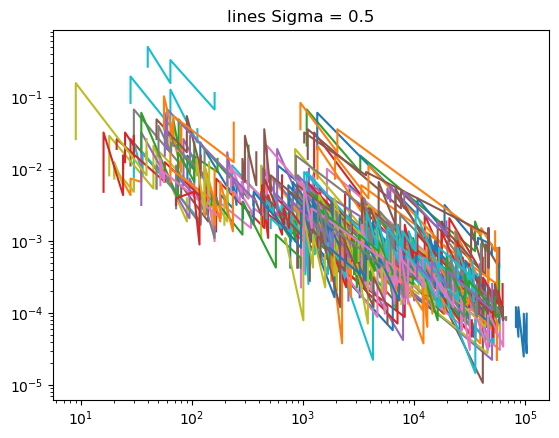

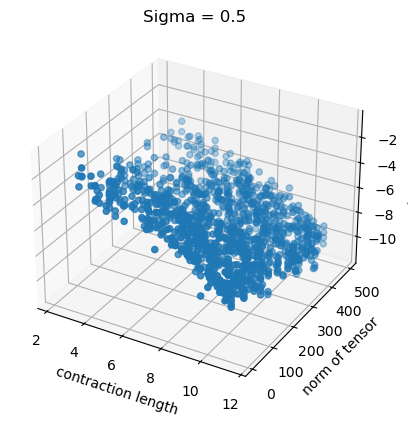

 
 
 Sigma = 0.1
Dimension of new tensor: [6, 146, 33, 3]
doing 5 iteration steps, with a norm of 224.34029088025437
done with factorization
Dimension of new tensor: [94, 7, 15, 4, 4]
doing 7 iteration steps, with a norm of 269.3336671924504
done with factorization
Dimension of new tensor: [164, 54, 5, 4]
doing 6 iteration steps, with a norm of 13.037248353876393
done with factorization
Dimension of new tensor: [6, 99, 10, 7, 3]
doing 6 iteration steps, with a norm of 352.2404744580841
done with factorization
Dimension of new tensor: [59, 19, 15, 3, 3]
doing 6 iteration steps, with a norm of 178.3809587611743
done with factorization
Dimension of new tensor: [159, 23, 4, 4, 3]
doing 5 iteration steps, with a norm of 413.09324149449617
done with factorization
Dimension of new tensor: [137, 102, 4, 3]
doing 7 iteration steps, with a norm of 120.51447216594647
done with factorization
Dimension of new tensor: [59, 148, 5, 3]
doing 6 iteration steps, with a norm of 162.2634411434303
done wit

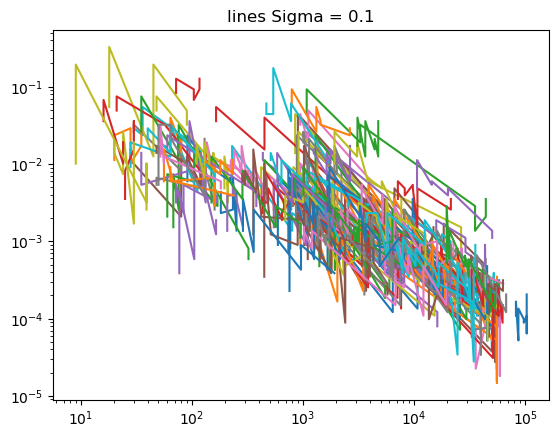

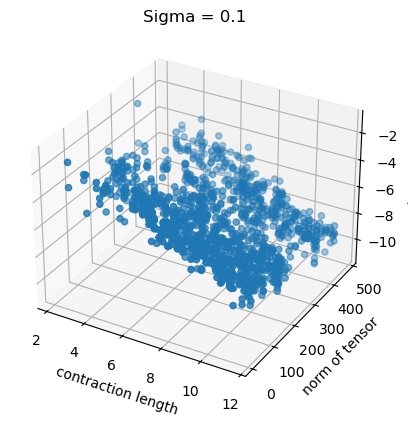

 
 
 Sigma = 0.001
Dimension of new tensor: [6, 146, 33, 3]
doing 7 iteration steps, with a norm of 380.5824100379708
done with factorization
Dimension of new tensor: [94, 7, 15, 4, 4]
doing 10 iteration steps, with a norm of 491.47286157631936
done with factorization
Dimension of new tensor: [164, 54, 5, 4]
doing 7 iteration steps, with a norm of 239.05372725987272
done with factorization
Dimension of new tensor: [6, 99, 10, 7, 3]
doing 8 iteration steps, with a norm of 200.15772133104028
done with factorization
Dimension of new tensor: [59, 19, 15, 3, 3]
doing 8 iteration steps, with a norm of 281.65298123148614
done with factorization
Dimension of new tensor: [159, 23, 4, 4, 3]
doing 9 iteration steps, with a norm of 157.3850525023849
done with factorization
Dimension of new tensor: [137, 102, 4, 3]
doing 6 iteration steps, with a norm of 446.4557867374411
done with factorization
Dimension of new tensor: [59, 148, 5, 3]
doing 9 iteration steps, with a norm of 417.8316931215023
done 

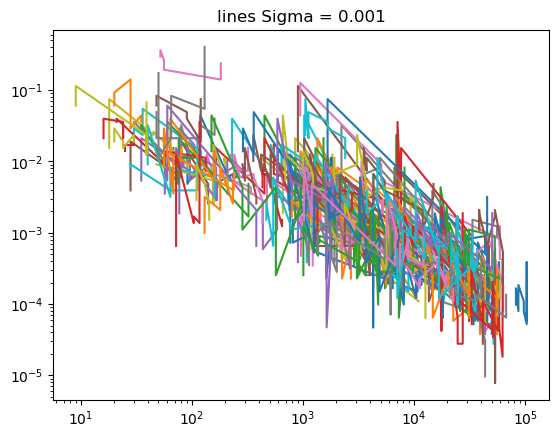

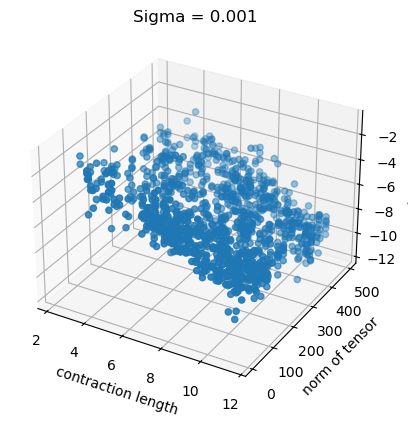

In [5]:
# Trying do plot many stuff things, you know...
# TODO make this use GPU! For some reason this is super slow on GPU even though it should be very fast?
#tl.set_backend('pytorch')
#context = {'dtype': tl.float32,
#           'device': 'cuda'}
tl.set_backend('numpy')
context = {}

dimensions = []
# add large tensors
for _ in range(50):
    ndim = random.randint(3, 5)
    dimension = []

    max_dimension = 300*300*2
    # TODO make tensor generation smarter so that we dont generate massive ones!
    for n in range(ndim):
        next_dimension = random.randint(3, max( min( int(max_dimension / 3**(ndim-n -1)), 200) , 3 ) )
        dimension.append(next_dimension)
        max_dimension /= next_dimension
        
    dimensions.append(dimension)

# add small tensors
for _ in range(100):
    ndim = random.randint(3, 5)
    dimension = []

    for _ in range(ndim):
        next_dimension = random.randint(3, 20 )
        dimension.append(next_dimension)
        
    dimensions.append(dimension)

# let us also test different sigma values
alpha = 0.5
beta = 0.9
sigmas = [0.5, 0.1, 0.001]

points_for_sigma = {}


for sigma in sigmas:
    print(" \n \n Sigma = " + str(sigma))
    all_points = [] # list containing all points
    
    # big tensors only for now
    for dimension in dimensions:
        print("Dimension of new tensor: " + str(dimension))
        
        F = random.randint(2, 5) # get random order between 2 and 5
        max_iter = random.randint(5, 10) # get a random iteration between 5 and 10 
        norm_of_tensor = random.uniform(1.0, 500.0) # get a random norm for our tensor
        
        data_of_tensor = []
        
        tensor = random_cp_with_noise(dimension, F, noise_scaling=0.0, context=context) # make it have no noise
        tensor = tensor * norm_of_tensor / tl.norm(tensor) # rescale the tensor

        
        print("doing " + str(max_iter) + " iteration steps, with a norm of " + str(norm_of_tensor))

        # creating initial data
        initial_A_ns = create_initial_data(tensor, F)
        norm_approx = tl.norm( defactorizing_CP(initial_A_ns, tensor.shape) )
        scaling = (norm_of_tensor / norm_approx) ** (1.0/ tensor.ndim)
        for n in range(len(initial_A_ns)):
            initial_A_ns[n] = initial_A_ns[n] * scaling

        try:
            A_ns, _, _, step_size_modfiers = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, sigma=sigma, beta=beta, initial_A_ns=initial_A_ns)
            print("done with factorization")
        except Exception as inst:
            print("got error")
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)
            continue
            
        for k in range(2): # always use the 2 last iterations to get bit more data points for free
            for n in range(tensor.ndim):
                khatr_rao_product = tl.tenalg.khatri_rao(A_ns, skip_matrix=n)
                data_of_tensor.append( (khatr_rao_product.shape[0], norm_of_tensor, alpha*math.pow(beta, step_size_modfiers[n][-k]) ) )

        # TODO: sort the points by x-axis so that plot looks better
        data_of_tensor = sorted(data_of_tensor, key=lambda x : x[0])
        all_points.extend(data_of_tensor) # add the points from this tensor to the list of all points
        contraction_lenghts = [e[0] for e in data_of_tensor]
        step_sizes = [e[2] for e in data_of_tensor]
        plt.plot(contraction_lenghts, step_sizes)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.title("lines Sigma = " + str(sigma))
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # this time do the log ourselfs
    contraction_lenghts = [math.log(e[0]) for e in all_points]
    norms = [e[1] for e in all_points]
    step_sizes = [math.log(e[2]) for e in all_points]
    
    ax.scatter(contraction_lenghts, norms, step_sizes)
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    ax.set_xlabel('contraction length')
    ax.set_ylabel('norm of tensor')
    ax.set_zlabel('step size')
    ax.set_title("Sigma = " + str(sigma))
    plt.show()

    points_for_sigma[sigma] = deepcopy(all_points)

try:
    pickle.dump( points_for_sigma, open(data_folder+'optimal_stepsize.pickle', 'wb') )
except Exception as e: print(e)

In [6]:
def fit_plane(points):
    """
    Fits the best 2D polynomial (plane) of the form z = ax + by + c to a set of 3D points.
    
    Args:
    points: A list or numpy array of 3D points, where each point is represented as [x, y, z].
    
    Returns:
    A tuple (a, b, c) representing the coefficients of the fitted plane.
    Returns None if there are fewer than 3 points.
    """
    points = np.array(points)
    if points.shape[0] < 3:
        print("Error: Need at least 3 points to fit a plane.")
        return None
    
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    
    # Construct the matrix A and vector b for the least squares fit
    # The equation is z = a*x + b*y + c, which can be written as:
    # [x1 y1 1] [a]   [z1]
    # [x2 y2 1] [b] = [z2]
    # ...       [c]   [...]
    A = np.vstack([x, y, np.ones(len(x))]).T
    b = z
    
    # Solve the least squares problem using numpy.linalg.lstsq
    coefficients, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    print("residual was " + str(residuals))
    
    # The coefficients are in the order [a, b, c]
    a, b, c = coefficients
    
    return a, b, c

 
 
 Sigma = 0.5
residual was [742.02730088]
(-0.647976179694208, -0.0045779574914963485, -0.5168312361681634)
so our formula is: step size = 0.30420669221882757 * length^(-0.647976179694208) * e^(-0.0045779574914963485norm)


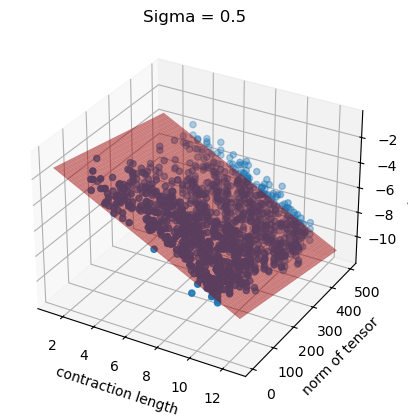

 
 
 Sigma = 0.1
residual was [794.29865483]
(-0.6419562061525151, -0.00460867034757114, -0.2964563922662487)
so our formula is: step size = 0.5052933791627682 * length^(-0.6419562061525151) * e^(-0.00460867034757114norm)


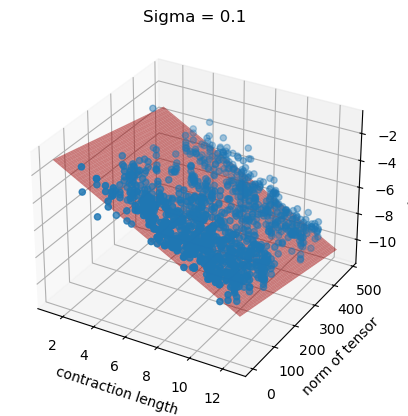

 
 
 Sigma = 0.001
residual was [1028.70220569]
(-0.6739995266506866, -0.003830867233456595, -0.23438498114542544)
so our formula is: step size = 0.5829281374506564 * length^(-0.6739995266506866) * e^(-0.003830867233456595norm)


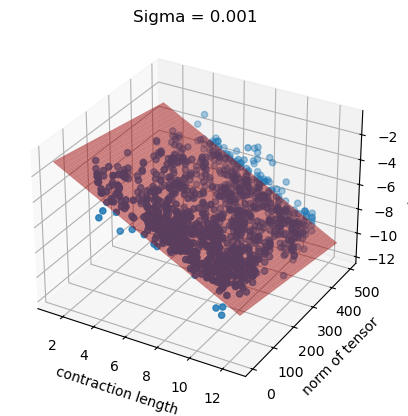

In [7]:
file = open(data_folder+"optimal_stepsize.pickle",'rb')
points_for_sigma = pickle.load(file)
file.close()

# iterate over all sigmas and print and plot the data
for sigma, all_points in points_for_sigma.items():
    
    contraction_lenghts = [math.log(e[0]) for e in all_points]
    norms = [e[1] for e in all_points]
    step_sizes = [math.log(e[2]) for e in all_points]
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(contraction_lenghts, norms, step_sizes)
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    ax.set_xlabel('contraction length')
    ax.set_ylabel('norm of tensor')
    ax.set_zlabel('step size')
    ax.set_title("Sigma = " + str(sigma))
    #plt.show()

    
    print(" \n \n Sigma = " + str(sigma))
    # let us now find the best 1d line through these points in loglog
    points = [(math.log(p[0]), p[1], math.log(p[2])) for p in all_points]
    coefficients = fit_plane(points)
    print(coefficients)
    # recalculate to exponential formula
    print("so our formula is: step size = " + str(math.pow(10, coefficients[2])) + " * length^(" + str(coefficients[0]) + ") * e^(" + str(coefficients[1]) + "norm)")
    #p = np.poly1d(z)
    #xp = np.linspace(min(x)-1, max(x)+1, 100)
    
    #_ = plt.plot(x, y, '.', xp, p(xp), '-')
    #plt.title("Sigma = " + str(sigma))
    a, b, c = coefficients
    xp = np.linspace(min(contraction_lenghts)-1, max(contraction_lenghts)+1, 100)
    yp = np.linspace(min(norms)-1, max(norms)+1, 100)
    X, Y = np.meshgrid(xp, yp)
    Z = a * X + b * Y + c
    ax.plot_surface(X, Y, Z, color='red', alpha=0.5, label='Fitted Plane')
    plt.show()

# es sieht so aus, als sei die ideale formel ca 5 / step_size^{0.87}

## Testing Fixed Step Size Algorithm


 
 Calculating the step size 

took 0.24299883842468262 seconds and 84 iterations with final error 0.09436072227444274

 
 Fixed step size 

took 0.23800015449523926 seconds and 221 iterations with final error 0.09424038150039167


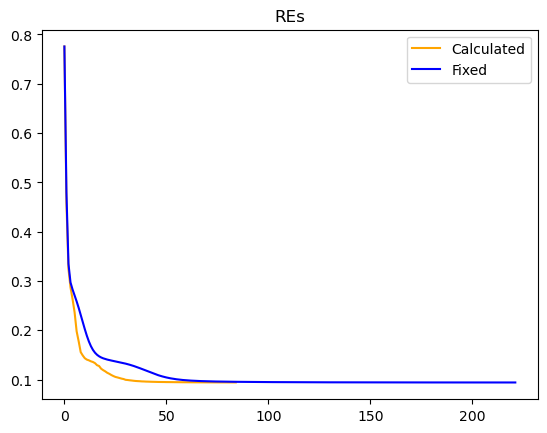

In [6]:
# FIXED STEP SIZE TEST AGAINST NORMAL ONE
dimension = (300, 30, 3)
F = 3
max_iter = 300
verbose = False

tensor = random_cp_with_noise(dimension, F)
# create initial data for both
initial_A_ns = create_initial_data(tensor, F)


# step size calculation
start = time.time()
_, RE_calc, approx_calc, step_size_modifiers_calc = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, initial_A_ns=initial_A_ns)
end = time.time()
time_calc = end - start
print("\n \n Calculating the step size \n")
print("took " + str(time_calc) + " seconds and " + str(len(RE_calc) - 1) + " iterations with final error " + str(RE_calc[-1]))

# fixed step size
start = time.time()
_, RE_fixed, approx_fixed, step_sizes_fixed = tensor_factorization_cp_poisson_fixed_step_size(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, initial_A_ns=initial_A_ns)
end = time.time()
time_fixed = end - start
print("\n \n Fixed step size \n")
print("took " + str(time_fixed) + " seconds and " + str(len(RE_fixed) - 1) + " iterations with final error " + str(RE_fixed[-1]))


plt.plot(RE_calc, label="Calculated", color="orange")
plt.plot(RE_fixed, label="Fixed", color="blue")
plt.title("REs")
plt.legend()
plt.show()

# Plotting Iteration of all 3 Algorithms

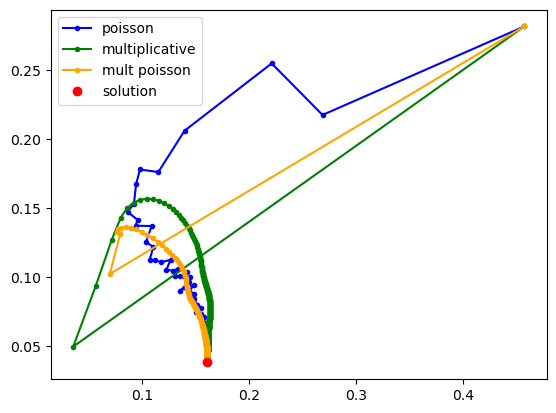

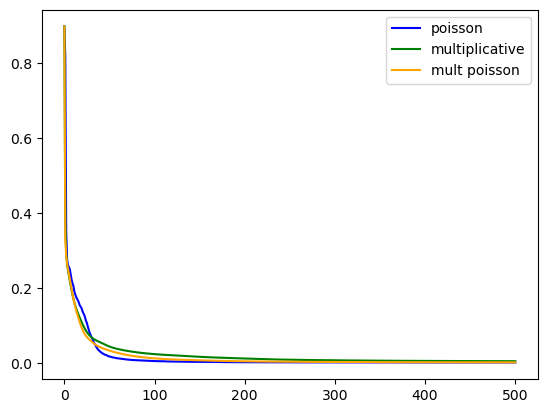

In [6]:
# plot part of the iteration by taking 2 Choords of the tensor and plotting there
tl.set_backend('numpy')
F = 3
max_iter = 500
index0 = (1, 1, 1)
index1 = (1, 1, 2)

tensor = random_cp_with_noise((100, 100, 3), F, noise_scaling=0.0)
initial_A_ns = create_initial_data(tensor, F)
A_ns_poisson = deepcopy(initial_A_ns)
A_ns_mult = deepcopy(initial_A_ns)
A_ns_mult_poisson = deepcopy(initial_A_ns)

intital_approx = defactorizing_CP(initial_A_ns, tensor.shape)

# list of tuples (index0, index1) during the iteration for the 3 algorithms
graph_poisson = [(intital_approx[index0], intital_approx[index1])] 
graph_mult = [(intital_approx[index0], intital_approx[index1])]
graph_mult_poisson = [(intital_approx[index0], intital_approx[index1])]

RE_poisson = [tl.norm(tensor - defactorizing_CP(initial_A_ns, tensor.shape)) / tl.norm(tensor)]
RE_mult = [tl.norm(tensor - defactorizing_CP(initial_A_ns, tensor.shape)) / tl.norm(tensor)]
RE_mult_poisson = [tl.norm(tensor - defactorizing_CP(initial_A_ns, tensor.shape)) / tl.norm(tensor)]

# achive this by always doing one iteration step from each algorithm
for i in range(max_iter):
    # Poisson algorithm
    A_ns_poisson, RE, approx_poisson, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=1, detailed=True, initial_A_ns=A_ns_poisson)
    graph_poisson.append( (approx_poisson[index0], approx_poisson[index1]) )
    RE_poisson.append(RE[-1])

    # Multiplicative algorithm
    A_ns_mult, RE, approx_mult = tensor_factorization_cp_multiplicative(tensor, F, max_iter=1, detailed=True, initial_A_ns=A_ns_mult)
    graph_mult.append( (approx_mult[index0], approx_mult[index1]) )
    RE_mult.append(RE[-1])

    # Multiplicative Poisson algorithm
    A_ns_mult_poisson, RE, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(tensor, F, max_iter=1, detailed=True, initial_A_ns=A_ns_mult_poisson)
    graph_mult_poisson.append( (approx_mult_poisson[index0], approx_mult_poisson[index1]) )
    RE_mult_poisson.append(RE[-1])





plt.plot([e[0] for e in graph_poisson], [e[1] for e in graph_poisson], marker='.', label='poisson', color='blue')
plt.plot([e[0] for e in graph_mult], [e[1] for e in graph_mult], marker='.', label='multiplicative', color='green')
plt.plot([e[0] for e in graph_mult_poisson], [e[1] for e in graph_mult_poisson], marker='.', label='mult poisson', color='orange')
# plot true solution
plt.plot(tensor[index0], tensor[index1], 'o', label='solution', color='red')
plt.legend()
plt.show()


plt.plot(RE_poisson, label='poisson', color='blue')
plt.plot(RE_mult, label='multiplicative', color='green')
plt.plot(RE_mult_poisson, label='mult poisson', color='orange')
plt.legend()
plt.show()

tensor([[0.0568, 0.1574, 0.1200, 0.1485, 0.0798, 0.0809, 0.2373, 0.1802, 0.0558,
         0.1099],
        [0.1199, 0.4109, 0.3104, 0.3940, 0.2676, 0.1877, 0.5350, 0.3403, 0.1562,
         0.3345],
        [0.1499, 0.2869, 0.1462, 0.2750, 0.1609, 0.1572, 0.3706, 0.2505, 0.1426,
         0.2375],
        [0.1186, 0.2517, 0.0995, 0.1635, 0.2600, 0.1987, 0.2914, 0.1810, 0.2220,
         0.1709],
        [0.1209, 0.3472, 0.0975, 0.2573, 0.3900, 0.2672, 0.3914, 0.2609, 0.3195,
         0.1721],
        [0.0775, 0.1475, 0.0770, 0.1440, 0.1087, 0.1313, 0.1327, 0.0931, 0.1348,
         0.0678],
        [0.1190, 0.2820, 0.1449, 0.2837, 0.2415, 0.1588, 0.3962, 0.2099, 0.1876,
         0.1953],
        [0.1036, 0.4361, 0.2557, 0.3574, 0.3988, 0.2273, 0.5175, 0.3236, 0.2856,
         0.3085],
        [0.1405, 0.2680, 0.2104, 0.2301, 0.1331, 0.1181, 0.4029, 0.2485, 0.0839,
         0.2134],
        [0.1093, 0.2989, 0.1584, 0.2138, 0.2378, 0.1859, 0.2764, 0.1892, 0.2250,
         0.1843]], device='c

Time for my implementation is: 0.0018736057565114756 seconds, in 269 iterations
Time for my implementation is: 0.0017674457195193268 seconds, in 215 iterations
Time for Tensorly implementation is: 0.002545050797032696 seconds, in 233 iterations


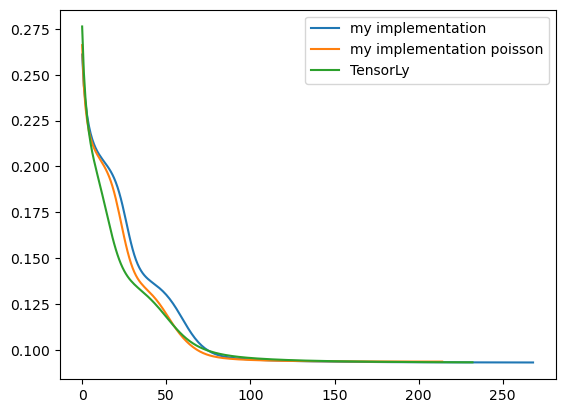

In [44]:
# comparing my multiplicative and TensorLys, as they are the same algorithm
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
X = random_cp_with_noise((300, 300, 3), 3, context=context)
F = 3

# first check my implementation
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
RE_mult.pop(0)
print("Time for my implementation is: " + str((end-start)/len(RE_mult)) + " seconds, in " + str(len(RE_mult)) + " iterations")

# first check my implementation for poisson
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
RE_mult_poisson.pop(0)
print("Time for my implementation is: " + str((end-start)/len(RE_mult_poisson)) + " seconds, in " + str(len(RE_mult_poisson)) + " iterations")

# TensorLy
start = time.time()
_, RE_tensorly = tl.decomposition.non_negative_parafac(X, F, init='random', n_iter_max=1000, return_errors=True)
end = time.time()
print("Time for Tensorly implementation is: " + str((end-start)/len(RE_tensorly)) + " seconds, in " + str(len(RE_tensorly)) + " iterations")

plt.plot([value.cpu() for value in RE_mult], label="my implementation")
plt.plot([value.cpu() for value in RE_mult_poisson], label="my implementation poisson")
plt.plot([value.cpu() for value in RE_tensorly], label="TensorLy")
plt.legend()
plt.show()

# Random Stuff

In [3]:
x = np.array([1.0, 2.0, 3.0, 4.0])
G = np.diag(1.0/x)
G_inv = np.diag(x)
print(G_inv)
dF = np.array([1.0, 2.0, 3.0, 4.0])
print(np.sum(dF * G_inv@dF))
print(np.sum(dF * x * dF))

A = np.random.rand(2,3)
dF = np.random.rand(2, 3)
print(tl.sum(dF * A * dF))
#print(
step_size_modifiers = []
for i in range(3):
    step_size_modifiers.append([])
print(step_size_modifiers)

[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 4.]]
100.0
100.0
0.5868339027092577
[[], [], []]


In [4]:
tensor = tl.random.random_tensor((10, 10))
tl.context(tensor)
tl.set_backend('pytorch')
print(tl.get_backend())
torch.cuda.is_available()

pytorch


True

# Step Size Testing

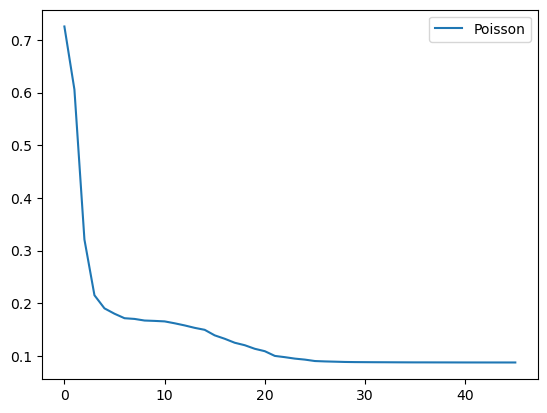

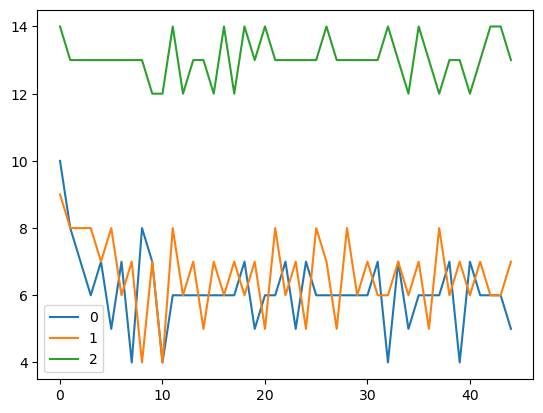

In [14]:
# Testing just poisson algo
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise

start = time.time()
A_ns, RE_poisson, approx_poisson, step_size_modifiers = tensor_factorization_cp_poisson(X, F, max_iter=100, detailed=True, verbose=False)
end = time.time()
plt.plot(RE_poisson, label="Poisson")
plt.legend()
plt.show()

for n, modifiers in enumerate(step_size_modifiers):
    plt.plot(modifiers, label=n)
plt.legend()
plt.show()

Poisson algorithm took 11.573360919952393 seconds with 191 iterations and had final error of 32.19194842080217
Multiplicative algorithm took 3.346959114074707 seconds with 537 iterations and had final error of 31.816133159364032
Multiplicative Poisson algorithm took 7.69700026512146 seconds with 605 iterations and had final error of 32.03727181146245
Muliplicative algorithm was 3.4578734085169542 times faster in total
Muliplicative algorithm was 9.754842878763618 times faster per iteration
Muliplicative Poisson algorithm was 4.779927760557137 times faster per iteration


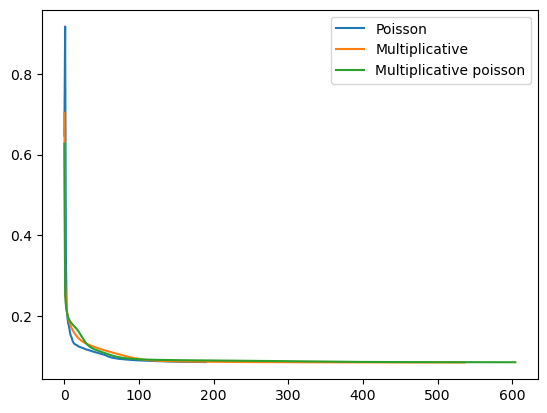

In [7]:
# Comparing on CPU
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 4
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative_poisson = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Multiplicative Poisson algorithm took " + str(time_multiplicative_poisson) + " seconds with " + str(len(RE_mult_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_mult_poisson)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
time_per_iteration_mult_poisson = time_multiplicative_poisson / (len(RE_mult_poisson) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")
print("Muliplicative Poisson algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult_poisson) + " times faster per iteration")
#print(tl.norm(A-tl.random.random_cp((4, 4, 4), 2, full=True)))
#plt.figure()
plt.plot(RE_poisson, label="Poisson")
plt.plot(RE_mult, label="Multiplicative")
plt.plot(RE_mult_poisson, label="Multiplicative poisson")
plt.legend()
plt.show()

Poisson algorithm took 0.5090031623840332 seconds with 67 iterations and had final error of tensor(26.9241, device='cuda:0')
Multiplicative algorithm took 0.14299726486206055 seconds with 96 iterations and had final error of tensor(26.3945, device='cuda:0')
Multiplicative Poisson algorithm took 0.23401212692260742 seconds with 149 iterations and had final error of tensor(26.6638, device='cuda:0')
Muliplicative algorithm was 3.5595307565849805 times faster in total
Muliplicative algorithm was 5.123566998114744 times faster per iteration


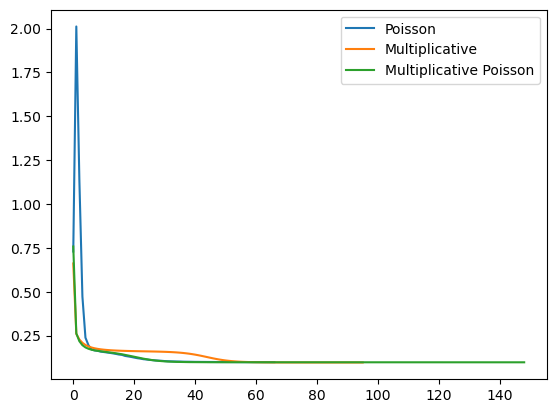

In [8]:
# Comparing on GPU with pytorch
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True, **context)
noise = tl.random.random_tensor(dimensions, **context) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative_poisson = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Multiplicative Poisson algorithm took " + str(time_multiplicative_poisson) + " seconds with " + str(len(RE_mult_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_mult_poisson)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")

plt.plot([value.cpu() for value in RE_poisson], label="Poisson")
plt.plot([value.cpu() for value in RE_mult], label="Multiplicative")
plt.plot([value.cpu() for value in RE_mult_poisson], label="Multiplicative Poisson")
plt.legend()
plt.show()

# Calculation Time of infividual parts of new algorithm

In [12]:
# comparing sqrt and exp

tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}

tensor = random_cp_with_noise((300, 300, 3), 4, context=context) - 0.5*tl.ones((300, 300, 3), **context)
A_ns = create_initial_data(tensor, 4)
beta = 0.5
alpha = 0.5

m = 1
N = 1000

exponential = tl.exp( math.pow(beta, m) * alpha * tensor)

# time recalculating exp
start = time.time()
m += 1
for i in range(N):
    update_exp =  tl.exp( math.pow(beta, m) * alpha * tensor)
end = time.time()
time_exp = end-start

# recalc using sqrt
start = time.time()
for i in range(N):
    update_sqrt = tl.sqrt(exponential)
end = time.time()
time_sqrt = end-start

print("time exponential = " + str(time_exp))
print("time sqrt = " + str(time_sqrt))

print("Difference in tensors = " + str(tl.max(tl.abs(update_exp - update_sqrt))))


# timing calculation speed of f
for n in range(3):
    start = time.time()
    khatri_rao_product = tl.tenalg.khatri_rao(A_ns, skip_matrix=n)
    f = lambda A: tl.sum( tl.matmul(A, tl.transpose(khatri_rao_product)) - tl.base.unfold(tensor, n) * tl.log( tl.matmul(A, tl.transpose(khatri_rao_product)) ))
    end = time.time()
    time_initialsetup = end - start
    start = time.time()
    for i in range(N):
        blob = f(A_ns[n])
    end = time.time()
    time_f = end-start
    # lets also check time for updating A_ns
    for i in range(N):
        blob = tl.exp(10.3*A_ns[n])
    end = time.time()
    time_exp = end - end
    # check time for khatri rao time A_n
    start = time.time()
    for i in range(N):
        blob = tl.matmul(A_ns[n], tl.transpose(khatri_rao_product))
    end = time.time()
    time_khatri_rao_prod = end-start
    # check time for logarithm
    start = time.time()
    for i in range(N):
        nope = tl.log(blob)
    end = time.time()
    time_log = end-start

    print("Time for initial setup: " + str(time_initialsetup))
    print("Time for f: " + str(time_f))
    print("Time for exp: " + str(time_exp))
    print("Time for khatri rao matmul A_n: " + str(time_khatri_rao_prod))
    print("Time for logarithm: " + str(time_log))

# test time for log
start = time.time()
for i in range(N):
    blob = tl.log(tensor)
time_log = time.time() - start

print("Time for log: " + str(time_log))




time exponential = 0.017000198364257812
time sqrt = 0.006000041961669922
Difference in tensors = tensor(1.1921e-07, device='cuda:0')
Time for initial setup: 0.0
Time for f: 0.125
Time for exp: 0.0
Time for khatri rao matmul A_n: 0.020999908447265625
Time for logarithm: 0.006000041961669922
Time for initial setup: 0.0
Time for f: 0.17000079154968262
Time for exp: 0.0
Time for khatri rao matmul A_n: 0.02299952507019043
Time for logarithm: 0.005999088287353516
Time for initial setup: 0.0
Time for f: 0.1380002498626709
Time for exp: 0.0
Time for khatri rao matmul A_n: 0.02200627326965332
Time for logarithm: 0.005993843078613281
Time for log: 0.006001949310302734


In [8]:
sorted(all_points, key=lambda x : x[0])

[(25, 0.5),
 (25, 0.5),
 (30, 0.25),
 (30, 0.5),
 (30, 0.5),
 (30, 0.125),
 (30, 0.25),
 (30, 0.5),
 (36, 0.25),
 (36, 0.5),
 (40, 0.25),
 (40, 0.5),
 (48, 0.0625),
 (48, 0.25),
 (55, 0.25),
 (55, 0.25),
 (84, 0.125),
 (84, 0.125),
 (88, 0.125),
 (88, 0.125),
 (91, 0.125),
 (91, 0.5),
 (112, 0.125),
 (112, 0.125),
 (120, 0.0625),
 (120, 0.0625),
 (140, 0.0625),
 (140, 0.0625),
 (156, 0.0625),
 (156, 0.0625),
 (204, 0.0625),
 (204, 0.25),
 (260, 0.03125),
 (260, 0.015625),
 (264, 0.015625),
 (264, 0.0625),
 (474, 0.0078125),
 (474, 0.03125),
 (625, 0.001953125),
 (625, 0.015625),
 (663, 0.015625),
 (663, 0.03125),
 (852, 0.0078125),
 (852, 0.015625),
 (876, 0.001953125),
 (876, 0.03125),
 (884, 0.03125),
 (884, 0.015625),
 (954, 0.0078125),
 (954, 0.03125),
 (972, 0.0078125),
 (972, 0.03125),
 (1180, 0.00390625),
 (1180, 0.015625),
 (2040, 0.0009765625),
 (2040, 0.015625),
 (2448, 0.00390625),
 (2448, 0.0078125),
 (2472, 0.00390625),
 (2472, 0.0078125),
 (2889, 0.0009765625),
 (2889, 0.

In [37]:
beta = 0.5
alpha = 0.5
sigma = 0.1
function_value_at_iteration = 100
norm_of_rg = 2000
m = math.ceil(math.log(function_value_at_iteration / (sigma * alpha * norm_of_rg)) / math.log(beta))

print(m)


print(math.ceil(math.log(function_value_at_iteration / (sigma * alpha * norm_of_rg), beta)))

0
0


In [36]:
tl.set_backend('numpy')
test = tl.random.random_tensor((2, 2, 2))
test.cpu()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

[tensor(0.7138, device='cuda:0'), tensor(0.2930, device='cuda:0'), tensor(0.2567, device='cuda:0'), tensor(0.2362, device='cuda:0'), tensor(0.2223, device='cuda:0'), tensor(0.2118, device='cuda:0'), tensor(0.2032, device='cuda:0'), tensor(0.1959, device='cuda:0'), tensor(0.1896, device='cuda:0'), tensor(0.1840, device='cuda:0'), tensor(0.1789, device='cuda:0')]
tensor([0.7138, 0.2930, 0.2567, 0.2362, 0.2223, 0.2118, 0.2032, 0.1959, 0.1896,
        0.1840, 0.1789])
11


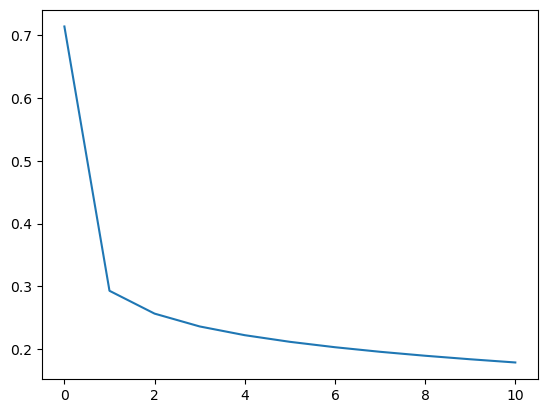

In [43]:
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}

GPU_tensor = random_cp_with_noise((10, 10, 10), 3, context=context)
A_ns, RE, _ = tensor_factorization_cp_multiplicative(GPU_tensor, 3, detailed=True, max_iter=10)

print(RE)
print(tl.tensor(RE))
print(len(tl.tensor(RE)))

plt.figure()
plt.plot(tl.tensor(RE))
plt.show()